In [1]:
import sys
sys.path.append('../lib/')

# To manage the paths
from astropy.io import fits
from glob import glob

from os import mkdir
from os.path import isdir
import pickle

# To compute centroids
from distortionMaps import d2cMapping # For centroids and mask 
from funcs import point_source_centroiding

# To get bad pixels flags
from jwst.datamodels import dqflags

import numpy as np
import matplotlib.pyplot as plt

# For PCA
from numpy import linalg # For PCA


version = "flt7"
cdpDir   = '../DATA/mrs_distortion_fits/'


# Notebook for Background (BKG) Subtraction Using PCA

### Organization of the Notebook
This notebook is designed to process entire folders of rate files, rather than handling individual files one at a time but one target at the time !

You can provide the path to the background (BKG) rate files and the folder containing the science rate files. This PCA-based subtraction method requires multiple observations in the same band and of different types to work effectively.

### Overview of the Process

#### **Step 1: Computing Centroids**
For each file, the centroid is computed using 2D fits, and relevant information (band/type) is conveniently stored. This avoids reopening the files multiple times throughout the process.
**/!\ This step will take some times !!!**

#### **Step 2: Background Subtraction Using PCA**

- **PCA Model:** For a given band, the corresponding BKG rate files are selected to compute the principal components (PCs). Using 20 PCs typically provides a well-refined background model.

- **PCA Projection Coefficients:**  
  Correctly projecting the BKG model without oversubtracting signal is challenging. We need to mask regions containing signal while preserving enough pixels in the med_frame to achieve accurate results. To achieve this, we combine two methods to determine the regions where projection coefficients should be computed:  
  1. To avoid signal contamination, we mask areas within a certain radius of the central star.  
  2. We apply the computed coefficients to the selected background regions.

- **Subtraction:**  
  The calculated projection coefficients are applied to each individual rate file of the target. The BKG-subtracted rate files are saved in the specified output directory.


## Parameters :

In [2]:
bkg_dir = "../DATA/BKG-mast/"
science_data_dir = '../DATA/pds70/sci_bfe_fringe/'#twhya/sci_bfe_fringe/'#"../STEP2-FRINGECORR/fringe_corr/"
centroid_save = True # Set to true if you have a pickel save of the centroids
outdir = "../DATA/pds70/sci_bfe_fringe_bkg/"#/twhya/sci_bfe_fringe_bkg/" # Will create itself if doesn exist.

v="flt7" # file version


nb_fwm_12 = 5 #How many fwm from the centroid should be masked
mflux_12 = 95  #percentil of brighest pixels to be masked
nb_fwm_34 = 3 #How many fwm from th‡e centroid should be masked
mflux_34 = 95  #percentil of brighest pixels to be masked

diff_bands = ['A12']#,'B34','C34','A12','B12','C12'] # Which band to process. MUST HAVE THE FORMAT "BANDCHAN" EX : (A12)

if glob(science_data_dir+"*rate.fits") ==[]: raise FileExistsError("No SCI rate file found at this path")
if glob(bkg_dir+"*.fits") ==[]: raise FileExistsError("No BKG rate file found at this path")


In [3]:
# Recommanded not to change

ncomp=20 # Number of PCA component - 20 is a good number of PC's for the bkg model. I do no recommand to change

band_to_letter = {"LONG":"C", "MEDIUM":"B", "SHORT":"A"} # Convert band name into letter

transmission = '80pc' 
wav_dict,fwhm_dict = {},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    wav_dict[band],fwhm_dict[band] = np.genfromtxt("../DATA/mrs_fwhm/"+'FWHM_detector_band{}.txt'.format(band),delimiter=',',unpack=True)
    
if not isdir(outdir): mkdir(outdir) 


## Step 1 : Computing Centroids

In [4]:
# %% Load the BKG files
cube_ref = []
band_CHAN_ref = []

for file in glob(bkg_dir+"*.fits"):
    
    ### -- load fits file and get infos
    hdul = fits.open(file)
    hdul.verify('ignore')
    frame = (hdul[1].data)

    # Read the band from the header
    cube_ref.append(frame)    
    band_CHAN_ref.append(band_to_letter[hdul[0].header["BAND"]]+hdul[0].header["CHANNEL"])    


In [5]:
# %% Load SCI (if there is a centriod save)

if centroid_save : 

    cube_sci = []
    name_list_sci = []
    bandCHAN_sci = []

    with open(science_data_dir+"centroids", 'rb') as handle:
        centers_list = pickle.load(handle)

    for file in glob(science_data_dir+"*rate.fits"):
        
        ### -- load fits file and get infos
        hdul = fits.open(file)
        hdul.verify('ignore')
        frame = (hdul[1].data)

        # Read the band from the header
        cube_sci.append(frame)    
        bandCHAN_sci.append(band_to_letter[hdul[0].header["BAND"]]+hdul[0].header["CHANNEL"])    
        name_list_sci.append(file.split('/')[-1])



In [6]:
# %% Load SCI if there is NO centriod save; will take some time.

if not centroid_save : 

    cube_sci = []
    name_list_sci = []
    bandCHAN_sci = []
    centers_list = []
    
    def get_spec_grid(d2cMaps):
        
        # spec_grid_left
        lambmin = np.nanmin(d2cMaps['lambdaMap'][np.where(d2cMaps['lambdaMap']!=0)]) # micron
        lambmax = np.nanmax(d2cMaps['lambdaMap']) # micron
        lambcens = np.arange(lambmin,lambmax,(lambmax-lambmin)/1024.)
        lambfwhms = np.ones(len(lambcens))*(2*(lambmax-lambmin)/1024.)    
        
        return [lambcens,lambfwhms]


    for file in glob(science_data_dir+"*rate.fits"):
        
        ### -- load fits file and get infos
        hdul = fits.open(file)
        hdul.verify('ignore')
        frame = (hdul[1].data)
        dq = hdul[3].data


        name =  file.split('/')[-1]
        band = band_to_letter[hdul[0].header["BAND"]]
        channel = hdul[0].header["CHANNEL"]
        
        # Create the mapping FOR BOTH CHANNEL
        if channel=='34': channel='43' # Inverse because 3 is right and 4 is left.
        band_left = channel[0]+band
        band_right = channel[1]+band
        d2cMaps_left = d2cMapping(band_left,cdpDir,slice_transmission=transmission, fileversion = v)
        d2cMaps_right = d2cMapping(band_right,cdpDir,slice_transmission=transmission, fileversion = v)

        ### -- Remove nan and bad pixels : 
        DO_NOT_USE = dqflags.pixel['DO_NOT_USE']
        NON_SCIENCE = dqflags.pixel['NON_SCIENCE']
        
        mask_bad = (np.bitwise_and(dq, DO_NOT_USE) == DO_NOT_USE)
        mask_non_science = (np.bitwise_and(dq, NON_SCIENCE) == NON_SCIENCE)
        frame[np.where(mask_bad+mask_non_science)]=np.nan

        ### --  Get centroid        
        # Left centorids
        centroid_2d = point_source_centroiding(band_left,frame,d2cMaps_left,spec_grid=get_spec_grid(d2cMaps_left), fit='2D', return_err=True)
        _ ,alpha_centers_l,beta_centers_l, _, _ ,_,  _ ,_,  = centroid_2d
        
        shiftx_l = np.nanmedian(alpha_centers_l)
        shifty_l = np.nanmedian(beta_centers_l)

        # Right centorids
        centroid_2d = point_source_centroiding(band_right,frame,d2cMaps_right,spec_grid=get_spec_grid(d2cMaps_right), fit='2D', return_err=True)
        _ ,alpha_centers_r,beta_centers_r,_, _ ,_ ,  _ ,_, = centroid_2d
        
        shiftx_r = np.nanmedian(alpha_centers_r)
        shifty_r = np.nanmedian(beta_centers_r)

        # If centroid estimation fail forchannel 4, you map centroid from channel 3 to channel 4. It required to dowanload and install miricoord.mrs.toolversions.mrs_tools_+version
        # Uncomment if required 
        """
        import importlib
        tv = importlib.import_module("miricoord.mrs.toolversions.mrs_tools_"+v)
        if channel[0]=="4" :
            
            # Centroid in alpha/beta of channel 3
            c_alpha_chanr = np.nanmedian(alpha_centers_r)
            c_beta_chanr = np.nanmedian(beta_centers_r)
                        
            # Map to centroid in V2/V3        
            c_v2, c_v3 = tv.abtov2v3(c_alpha_chanr, c_beta_chanr, band_right)
            
            # Map back to alpha/beta for channel 4  
            c_alpha_chanl, c_beta_chanl = tv.v2v3toab(c_v2, c_v3,band_left)
            
            # Convert into centroid in pixel 
            shiftx_l = c_alpha_chanl
            shifty_l = c_beta_chanl
        """         
           
        if np.all(np.isnan(alpha_centers_l)) : shiftx_l=0
        if np.all(np.isnan(alpha_centers_r)) :  shiftx_r=0
        if np.all(np.isnan(beta_centers_l)) : shifty_l=0
        if np.all(np.isnan(beta_centers_r)) :  shifty_r=0

        # Store it in 2x2 tuple
        centers_list.append( ((shiftx_l,shifty_l), 
                            (-shiftx_r,-shifty_r)) )
        cube_sci.append( frame )
        bandCHAN_sci.append(band_to_letter[hdul[0].header["BAND"]]+hdul[0].header["CHANNEL"])    
        name_list_sci.append(name)    
        
    # OPTIONAL (save the centroid list to avoid re-compute it !!)
    with open(science_data_dir+"centroids", 'wb') as handle:
        pickle.dump((centers_list), handle)


In [7]:
# plt.figure(figsize=(7,3))
# plt.title("Before / after subtraction")
# plt.plot(log_frame_test[512], c="lightgray", alpha=0.7, lw=3, label="Before bkg sub")
# plt.plot(pca_residu[512], color="tab:blue",  label="After bkg sub")
# plt.yscale("symlog")
# plt.plot(len(log_frame_test[512])*[0],'r', alpha=0.7)
# plt.legend()
# plt.savefig("bkgres.png",dpi=400)

## Step 2: Background Subtraction Using PCA


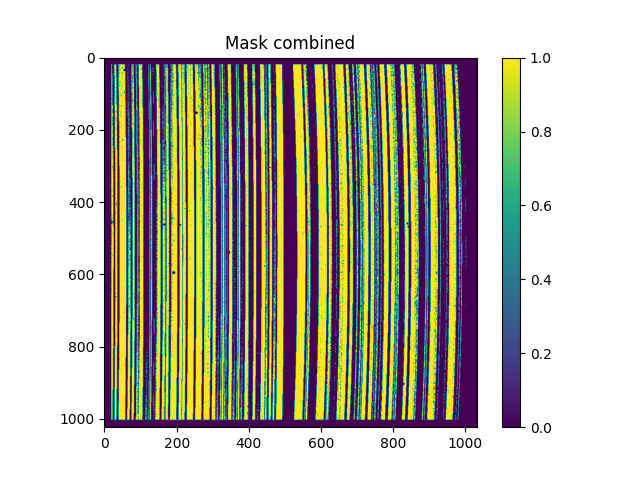

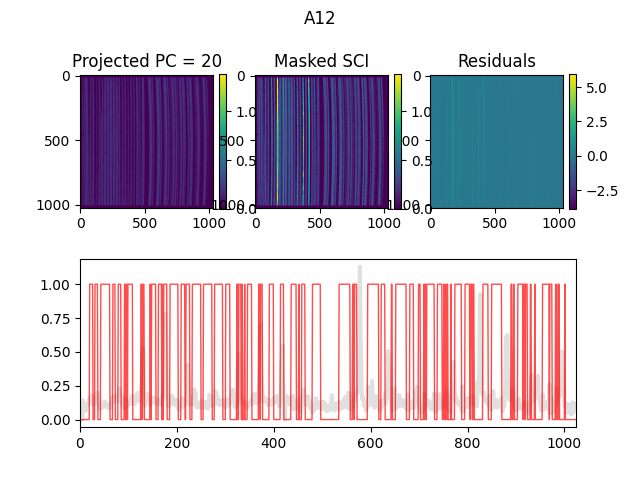

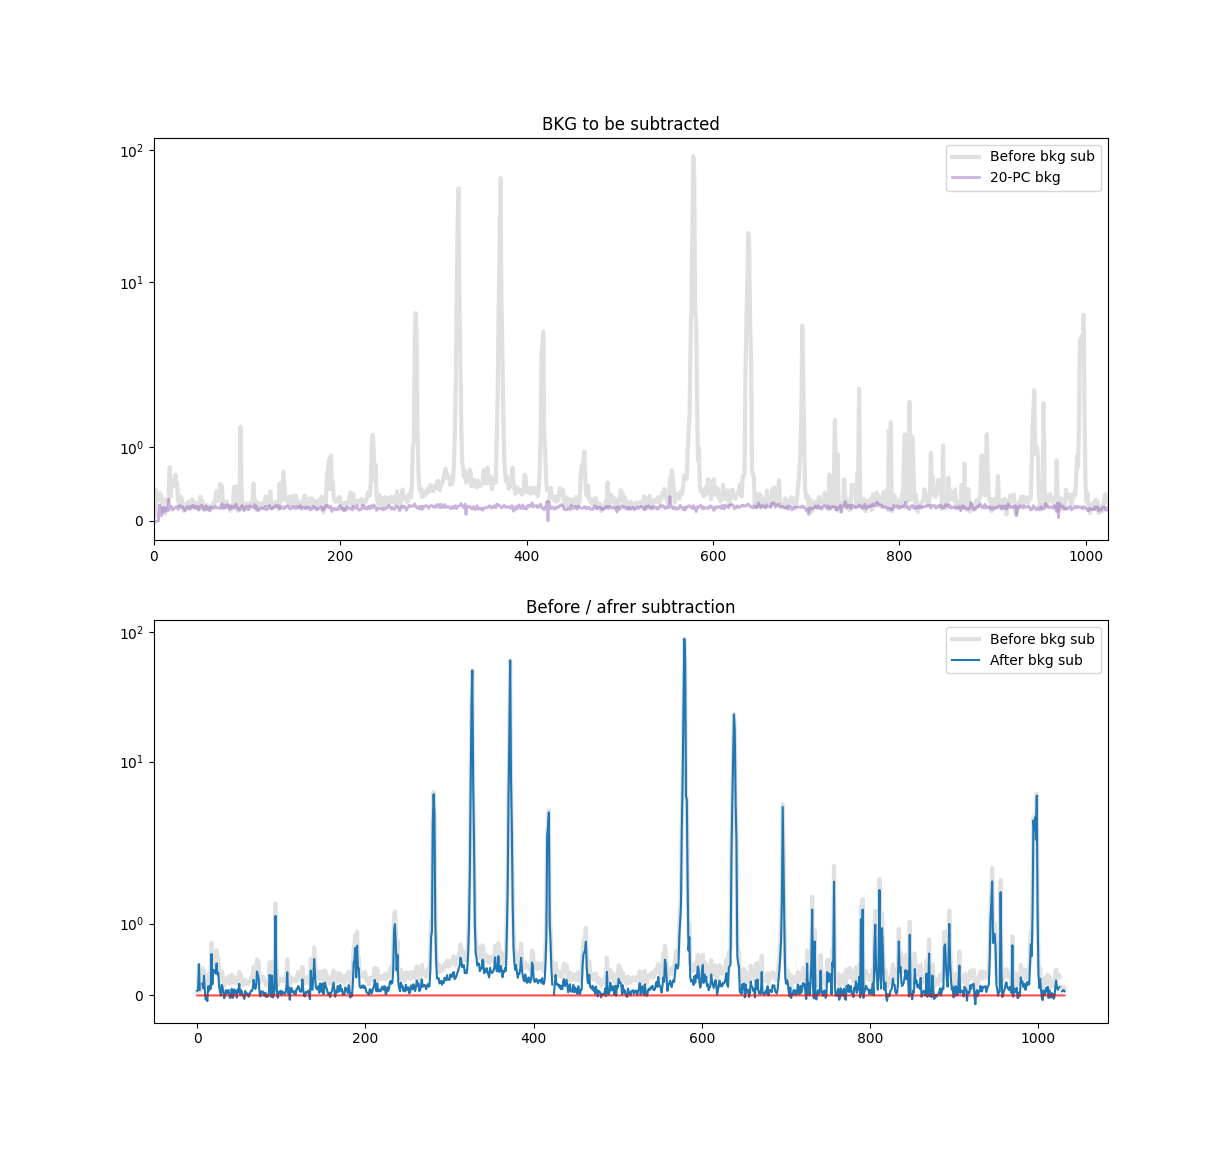

In [8]:
%matplotlib widget
itegrated_flx = 0 # TO COMPUTE THE FLUX WE REMOVE - FOR PLOTTING PURPOSED ONLY

cube_sci = np.array(cube_sci)
name_list_sci = np.array(name_list_sci)
centers_list = np.array(centers_list)

bandCHAN_sci = np.array(bandCHAN_sci)
cube_ref = np.array(cube_ref)
band_CHAN_ref = np.array(band_CHAN_ref)

def flush_current_figs():
    plt.clf()
    plt.cla()
    plt.close("all")


def multipage(filename, figs=None, dpi=400):
    from matplotlib.backends.backend_pdf import PdfPages

    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()


for kk, band_i in enumerate(diff_bands) : 
    
    # Select sci and bkg files with appropriate band    
    indices_ref = [i for i, x in enumerate(band_CHAN_ref) if x == band_i]
    cube_frame_band_i = cube_ref[indices_ref]  
    
    indices_sci = [i for i, x in enumerate(bandCHAN_sci) if x == band_i]
    cube_frame_band_i_sci = cube_sci[indices_sci]  
    name_list_sci_i = name_list_sci[indices_sci]
    centers_band_i_sci = centers_list[indices_sci]
    med_frame = np.median(cube_frame_band_i_sci, axis=0)

    # Flatten the matrix as 2D, nb_frame X frame_size
    cubeflat = cube_frame_band_i.reshape((cube_frame_band_i.shape[0],-1))
    
    
    # Get rid of nans 
    cubeflat[np.isnan(cubeflat)]=0      
    ignor = np.isnan(med_frame)
    med_frame[ignor] = 0

    for ll in range(len(cube_frame_band_i)):
        cube_frame_band_i[ll, ignor]=0   


    ## -- Compute SVD.
    U, S, V = linalg.svd(cubeflat, full_matrices=False)
    V = V[:ncomp] # We keep ncomp PC's
        
    # -- Check CVR
    # eigval = linalg.eigvals(np.cov(cubeflat))
    # plt.figure("CVR"+str(kk))
    # cvr = np.cumsum(eigval) / np.sum(eigval)
    # plt.plot(cvr)

    ## -- MASKING
    
    # Create mask for the borders.
    border_mask = np.ones(med_frame.shape)
    border_mask[:20,:]=0
    border_mask[-20:,:]=0
    border_mask[:,-20:]=0
    border_mask[:,:20]=0

    bandchanL = band_i[1]+band_i[0]
    bandchanR = band_i[2]+band_i[0]
    nb_fwm = nb_fwm_12
    mflux = mflux_12
    
    if bandchanL[0]=='3':
        bandchanR = band_i[1]+band_i[0]
        bandchanL = band_i[2]+band_i[0]
        nb_fwm = nb_fwm_34
        mflux = mflux_34

    mask_list = np.zeros(med_frame.shape)
    plt.figure("MASK"+str(kk))

    for ii in range(len(cube_frame_band_i_sci)):

        frame_i = cube_frame_band_i_sci[ii]
        (shiftx_l,shifty_l), (shiftx_r,shifty_r)  = centers_band_i_sci[ii]
        d2cMaps_left = d2cMapping(bandchanL,cdpDir,slice_transmission=transmission,fileversion = "flt7")
        d2cMaps_right = d2cMapping(bandchanR,cdpDir,slice_transmission=transmission,fileversion = "flt7")

        radius_map = np.sqrt((d2cMaps_left['alphaMap']-shiftx_l)**2 + (d2cMaps_left['betaMap']-shifty_l)**2)
        mask_L = (radius_map>nb_fwm*np.mean(fwhm_dict[bandchanL]) ) * d2cMaps_left["sliceMap"]

        radius_map = np.sqrt((d2cMaps_right['alphaMap']-shiftx_r)**2 + (d2cMaps_right['betaMap']-shifty_r)**2)
        mask_R = (radius_map>nb_fwm*np.mean(fwhm_dict[bandchanR]) ) * d2cMaps_right["sliceMap"]

        mask  = ~ignor * border_mask * mask_L * (mask_L * frame_i < np.nanpercentile(mask_L * frame_i, mflux))
        maskR = ~ignor * border_mask * mask_R * (mask_R * frame_i < np.nanpercentile(mask_R * frame_i, mflux)) 
        mask[:,512:] = maskR[:,512:]

        mask_list += (mask !=0)


    mask = (mask_list >= 2)
    plt.imshow(mask), plt.title("Mask combined"),plt.colorbar()

    masked_frame = (mask * med_frame).flatten()
    maskedV = mask.flatten() * V[:]
    
    ## -- Projection

    # Compute proj coeff using masked PC and masked med_frame.
    coeff = np.dot(masked_frame, maskedV.T)
   
    # Apply coeff to unmasked PC to obtain bkg model
    pcaPSF = np.dot(coeff.T, V)
        
    # Reshape
    pcaPSF = pcaPSF.reshape(med_frame.shape)
    
    # Subtract the PCA BKG model to each inficidual 
    for ii in range(len(cube_frame_band_i_sci)):
        
        pca_residu = (cube_frame_band_i_sci[ii] - pcaPSF)
        hdul = fits.open(science_data_dir+"/"+name_list_sci_i[ii])
        hdul.verify('ignore')
        hdul[1].data = pca_residu 

        hdul.writeto(outdir+name_list_sci_i[ii], overwrite=True)

    ## -- PLOTS
    pcaPSF = pcaPSF.flatten()

    pca_residu = (med_frame.flatten() - pcaPSF)
    masked_frame = mask * med_frame
    maskedV = mask * pcaPSF.reshape(med_frame.shape)
    masked_residu = mask * pca_residu.reshape(med_frame.shape)

    # This plot 1D and 2D results
    plt.figure("mask"+str(kk))
    
    plt.subplot(233), plt.imshow(masked_residu), plt.title("Residuals"), plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(231), plt.imshow(maskedV, vmax=np.percentile(masked_frame, 99),vmin=0),plt.title("Projected PC = "+str(ncomp)), plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(232), plt.imshow(masked_frame, vmax=np.percentile(masked_frame, 99), vmin=0), plt.title("Masked SCI"), plt.colorbar(fraction=0.046, pad=0.04)
    plt.suptitle(band_i)

    plt.subplot(212)
    plt.plot(np.log10(1+med_frame[512]), c="lightgray", alpha=0.7, lw=3, label="sci med_frame")
    plt.plot(mask[512], c="red", alpha=0.7, lw=1, label="mask")

    plt.text(0, -1, "Plots with combined SCI.")

    plt.xlim([0,1024])

    plt.figure("only one row"+str(kk), figsize=(12.31,11.49))

    pca_residu = (cube_frame_band_i_sci[0] - pcaPSF.reshape(med_frame.shape))        
    frame_test = cube_frame_band_i_sci[0]
    pcaPSF = pcaPSF.reshape(med_frame.shape)

    plt.subplot(211)
    plt.plot()
    plt.plot(frame_test[512], c="lightgray", alpha=0.7, lw=3, label="Before bkg sub")
    plt.plot(pcaPSF[512], "tab:purple", lw=2, alpha=0.5, label=str(ncomp)+"-PC bkg")
    plt.yscale("symlog")
    plt.title("BKG to be subtracted")
    plt.xlim([0,1024])
    plt.legend()
    plt.yscale("symlog")
    plt.subplot(212)
    plt.title("Before / afrer subtraction")
    plt.plot(frame_test[512], c="lightgray", alpha=0.7, lw=3, label="Before bkg sub")

    plt.plot(pca_residu[512], color="tab:blue",  label="After bkg sub")
    plt.plot(len(frame_test[512])*[0],'r', alpha=0.7)
    plt.legend()
    plt.yscale("symlog")
    
    itegrated_flx += np.sum(abs(pcaPSF))

multipage("./res.pdf")
